# Zillow Clustering Porject

## Executive Summary

Goals: Build a new regression model to predict logerror (log(Zestimate) - log(SalePrice)), and use clustering to see if we can find groups of similar observations to generate new features to be fed into our supervised model.

## Objectives for this project include:

Identify the drivers for logerrror by using clustering methodologies.

Document the process and analysis throughout the data science pipeline.

Demonstrate the information that was discovered.

In [1]:
#imports
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score
from scipy.stats import f_oneway

import wrangle as w
import explore as e
import model as m

### Wrangling

Acquire Zillow data from Codeup database, and turn it into a .csv for quicker use

In [2]:
#get our data, turn into .csv, and check shape
df = w.get_zillow_data()
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,11677,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2288172,NaN,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,266.0,2.0,NaN,NaN,1.0,10887214,1970746,NaN,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
#Check how many missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77575 entries, 0 to 77574
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77575 non-null  float64
 3   heatingorsystemtypeid         49570 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      206 non-null    float64
 6   airconditioningtypeid         25006 non-null  float64
 7   parcelid                      77575 non-null  int64  
 8   id                            77575 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77575 non-null  float64
 11  bedroomcnt                    77575 non-null  float64
 12  buildingqualitytypeid         49809 non-null  float64
 13  c

Takeaways:

Lots of missing values Some columns have inaccurate content? Let's just clean it up for now, and we'll decide what we want to explore on later

Prepare our data for mostly-ready use. We're going to rename columns, make dummies, create new features, drop outliers, and drop columns and rows with more than 50% missing values.

In [4]:
#Clean zillow and then look at the df once again
df = w.prepare_zillow(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49727 entries, 0 to 77574
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   propertylandusetypeid       49727 non-null  float64
 1   parcel_id                   49727 non-null  int64  
 2   id                          49727 non-null  int64  
 3   baths                       49727 non-null  float64
 4   beds                        49727 non-null  float64
 5   calculatedbathnbr           49713 non-null  float64
 6   sqft                        49727 non-null  float64
 7   finishedsquarefeet12        49546 non-null  float64
 8   fullbathcnt                 49713 non-null  float64
 9   latitude                    49727 non-null  float64
 10  longitude                   49727 non-null  float64
 11  lotsizesquarefeet           49727 non-null  float64
 12  propertycountylandusecode   49727 non-null  object 
 13  rawcensustractandblock      497

In [5]:
#split into train, validate, test. Our target is logerror
train, validate, test = w.train_validate_test_split(df, 'logerror', seed=1234)

In [6]:
#imputation preserves all cases by replacing missing data with an estimated value 
#based on other available information
#return our train, validate, and test sets with calculatedbathnbr, fullbathcnt, regionidcity, regionidzip,censustractandblock
#imputed with most frequent values
train, validate, test = w.impute_nulls(train, validate, test, strategy='most_frequent', 
                        col_list=['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'censustractandblock'])

In [7]:
#return our train, validate, and test sets with finishedsquarefeet12, lotsizesquarefeet, structuretaxvaluedollarcnt, 
#tax_value, land tax value dollar count, and tax amount imputed with the column's median value. 
train, validate, test = w.impute_nulls(train, validate, test, strategy='median', 
                        col_list=['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 
                                  'tax_value', 'landtaxvaluedollarcnt', 'tax_amount'])

In [8]:
#checking there are no more nulls in train valdiate and test
train.isna().sum().sum(), validate.isna().sum().sum(), test.isna().sum().sum()

(67, 47, 25)

In [9]:
#drop rows with remaining nulls from all of our split sets
train = train.dropna()
validate = validate.dropna()
test = test.dropna()

In [10]:
#assuring there are no more nulls and we can almost get to work
train.isna().sum().sum(), validate.isna().sum().sum(), test.isna().sum().sum()

(0, 0, 0)

In [11]:
#total rows and columns that are left to work with 
#train should have most dataset
#47 columns in each dataset
train.shape, validate.shape, test.shape

((27805, 44), (11908, 44), (9932, 44))

In [12]:
#split new train, validate, and test into X_train, y_train, X_validate, y_validate, X_test, y_test with logerror as our target
X_train, y_train, X_validate, y_validate, X_test, y_test = w.split_X_y(train, validate, test, 'logerror')

In [13]:
#get object columns, and numeric columns so we can scale our data
obj_cols = w.get_object_cols(X_train)
num_cols = w.get_numeric_X_cols(X_train, obj_cols)

Wrangle Takeaways:

- Our data is now clean, and split into train, validate and test.
- We dropped any rows and columns with more than 50% missing values 
- Dropped, filled, or imputed for remaining missing values 
- We went from 77,575 rows to 49,727rows. At the start, we had 68 columns, after the data is cleaned, now 47 columns.

### Explore

Hypothesis List

1.) Log error is affected by square footage, number of bedrooms and bathrooms.

2.) Log error is affected by property age

3.) Log error is affected by location

4.) Log error is affected by price per sq ft.

5.) Log error is affected by combinations of internal property features and combinations of locational features.



### Univariate Explore

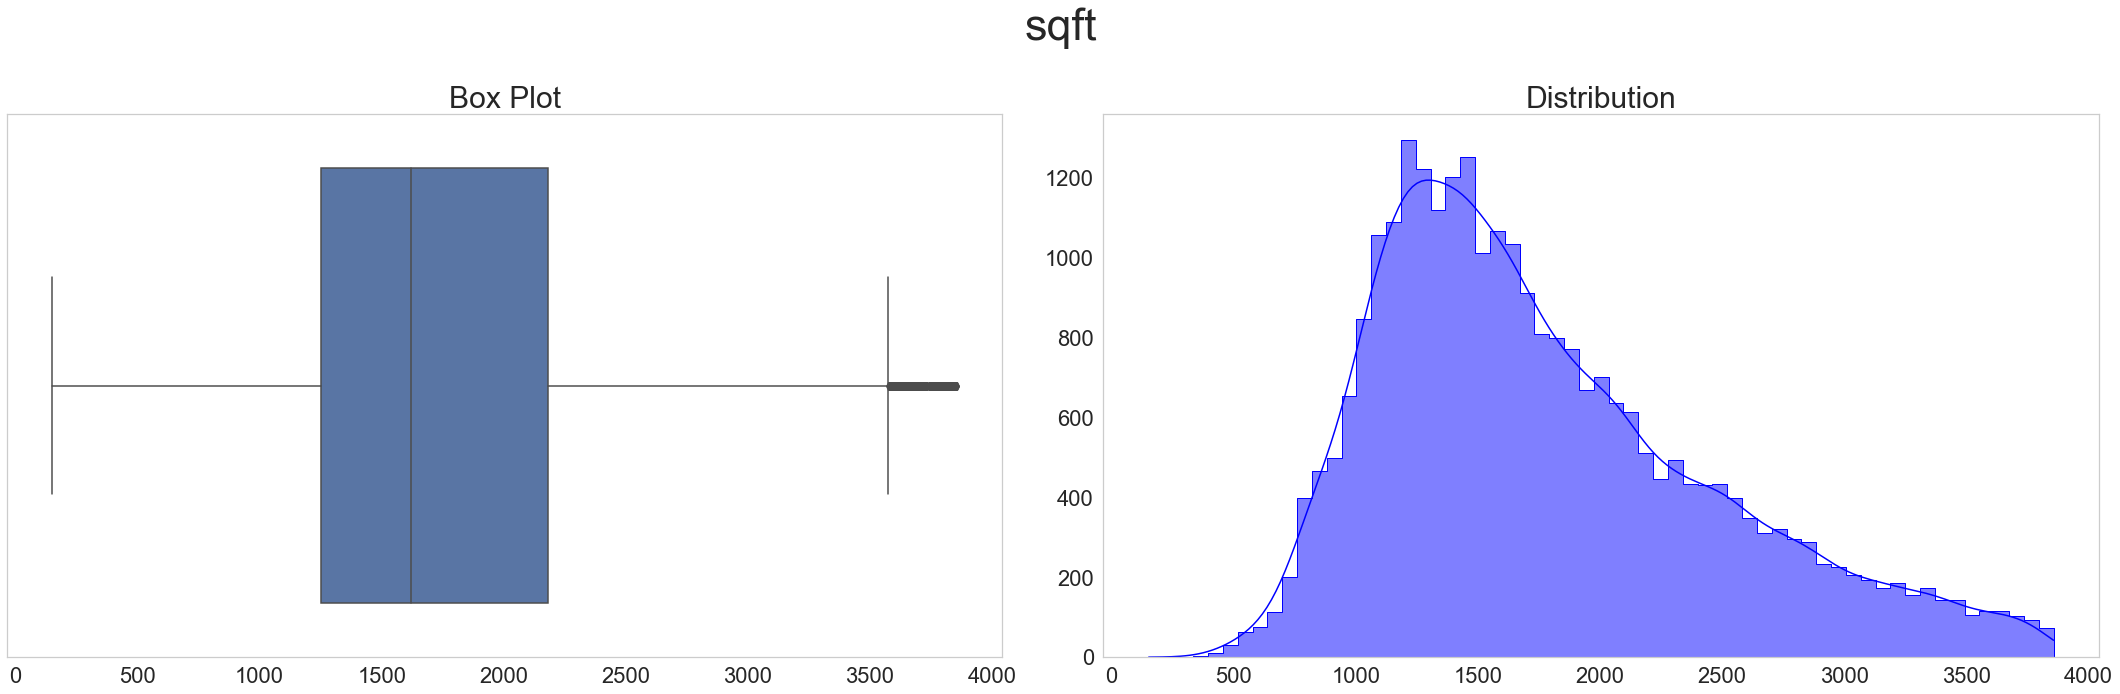

Summary Statistics for sqft
count    27805.000000
mean      1778.215429
std        695.838172
min        152.000000
25%       1252.000000
50%       1622.000000
75%       2181.000000
max       3857.000000
Name: sqft, dtype: float64


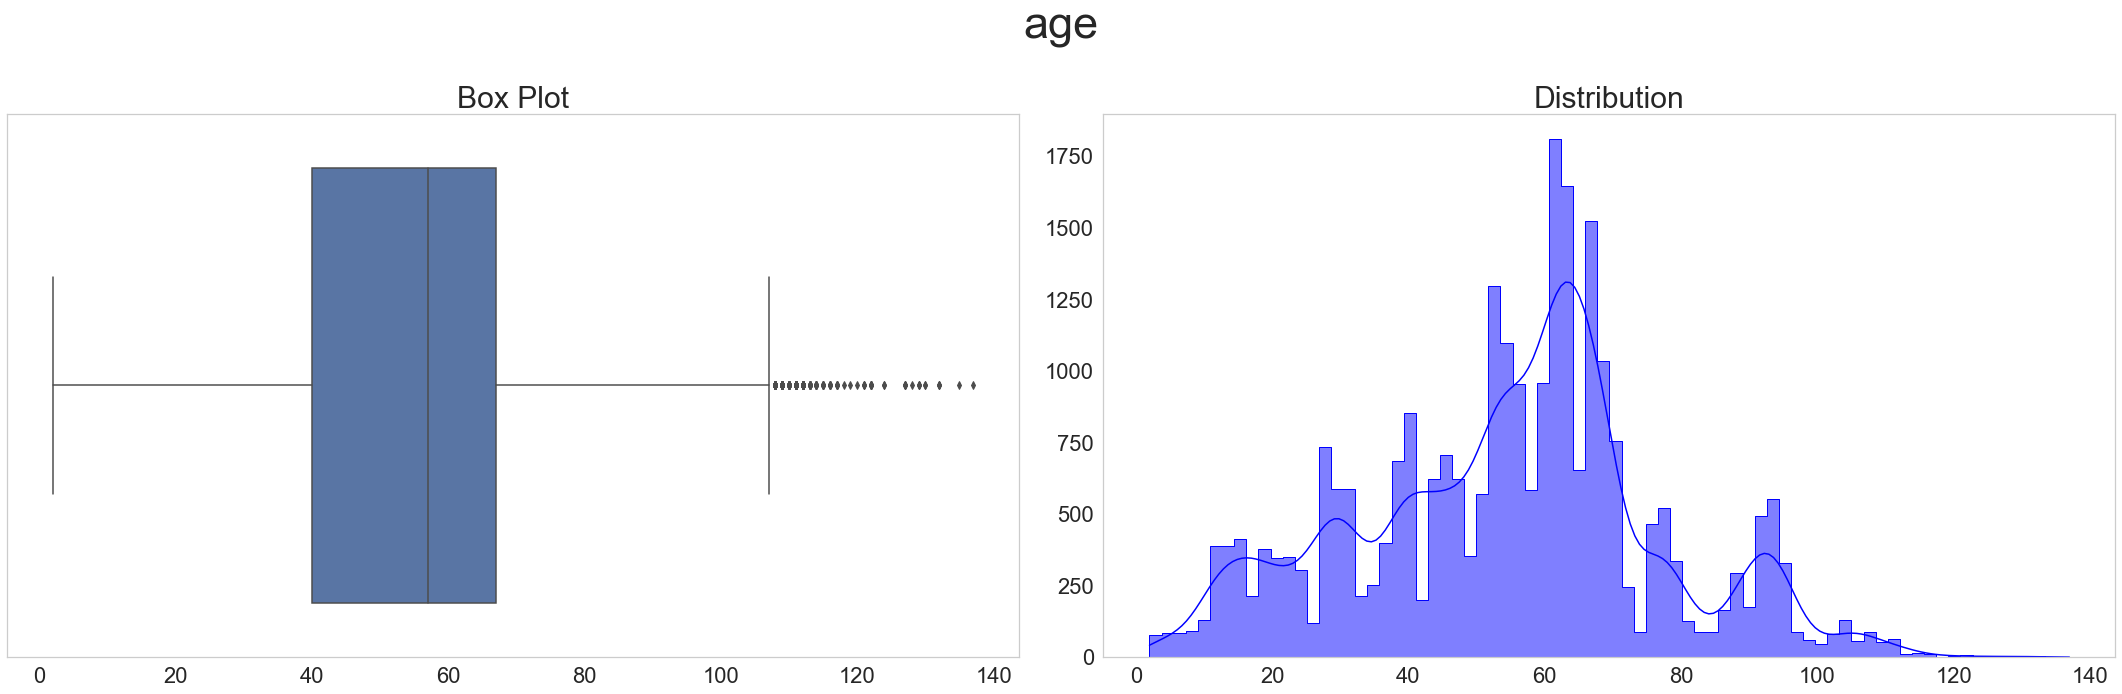

Summary Statistics for age
count    27805.000000
mean        54.604100
std         22.318244
min          2.000000
25%         40.000000
50%         57.000000
75%         67.000000
max        137.000000
Name: age, dtype: float64


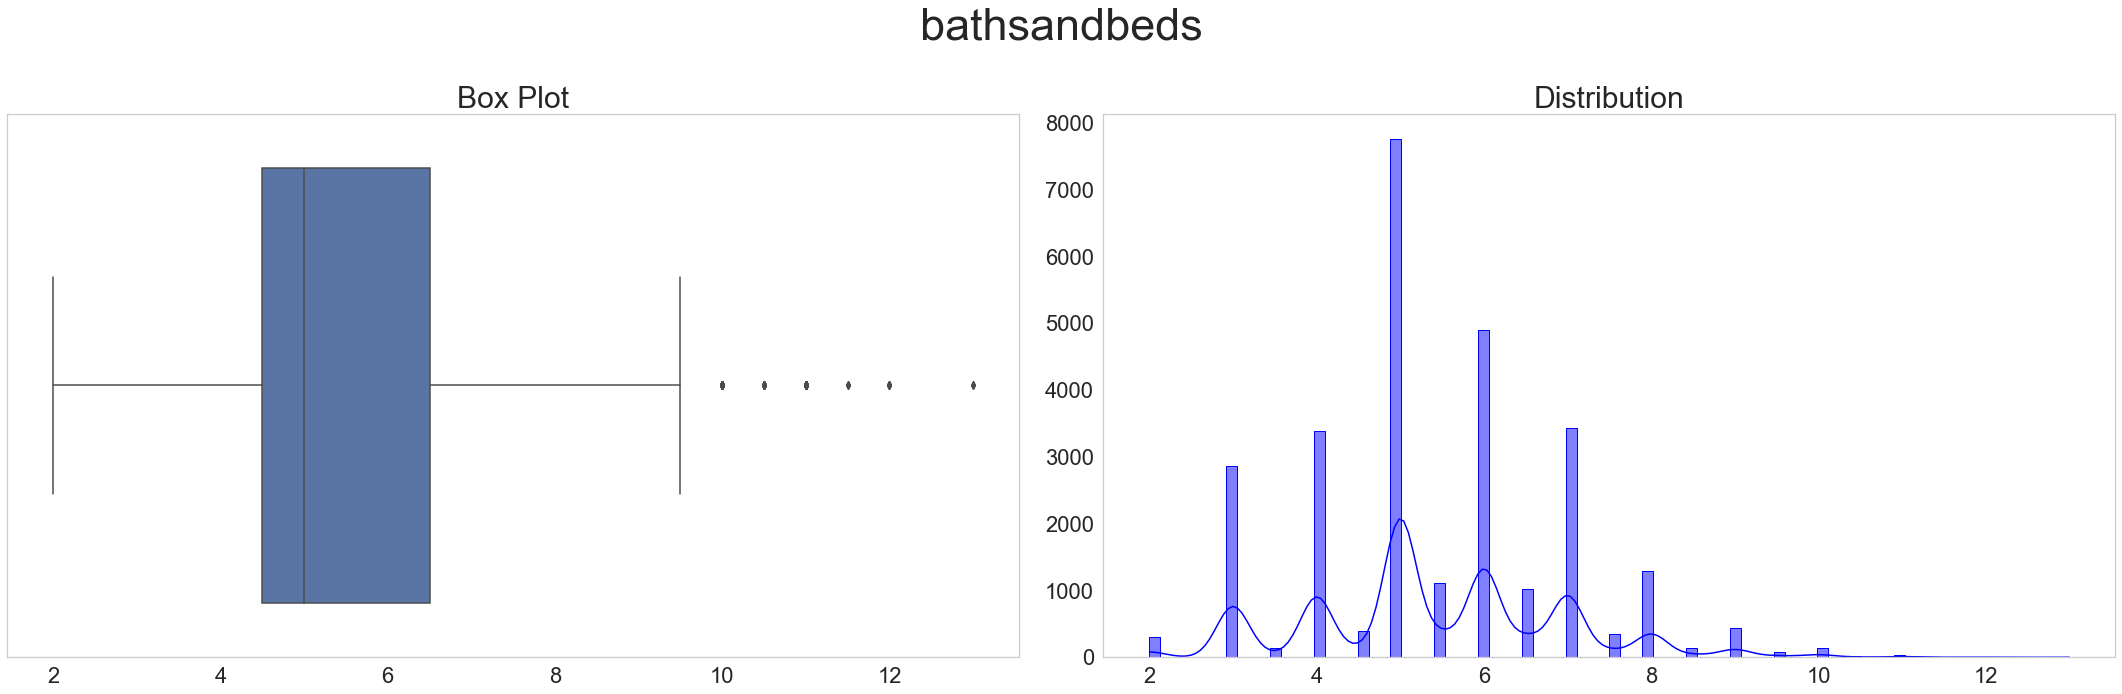

Summary Statistics for bathsandbeds
count    27805.000000
mean         5.430282
std          1.520902
min          2.000000
25%          4.500000
50%          5.000000
75%          6.500000
max         13.000000
Name: bathsandbeds, dtype: float64


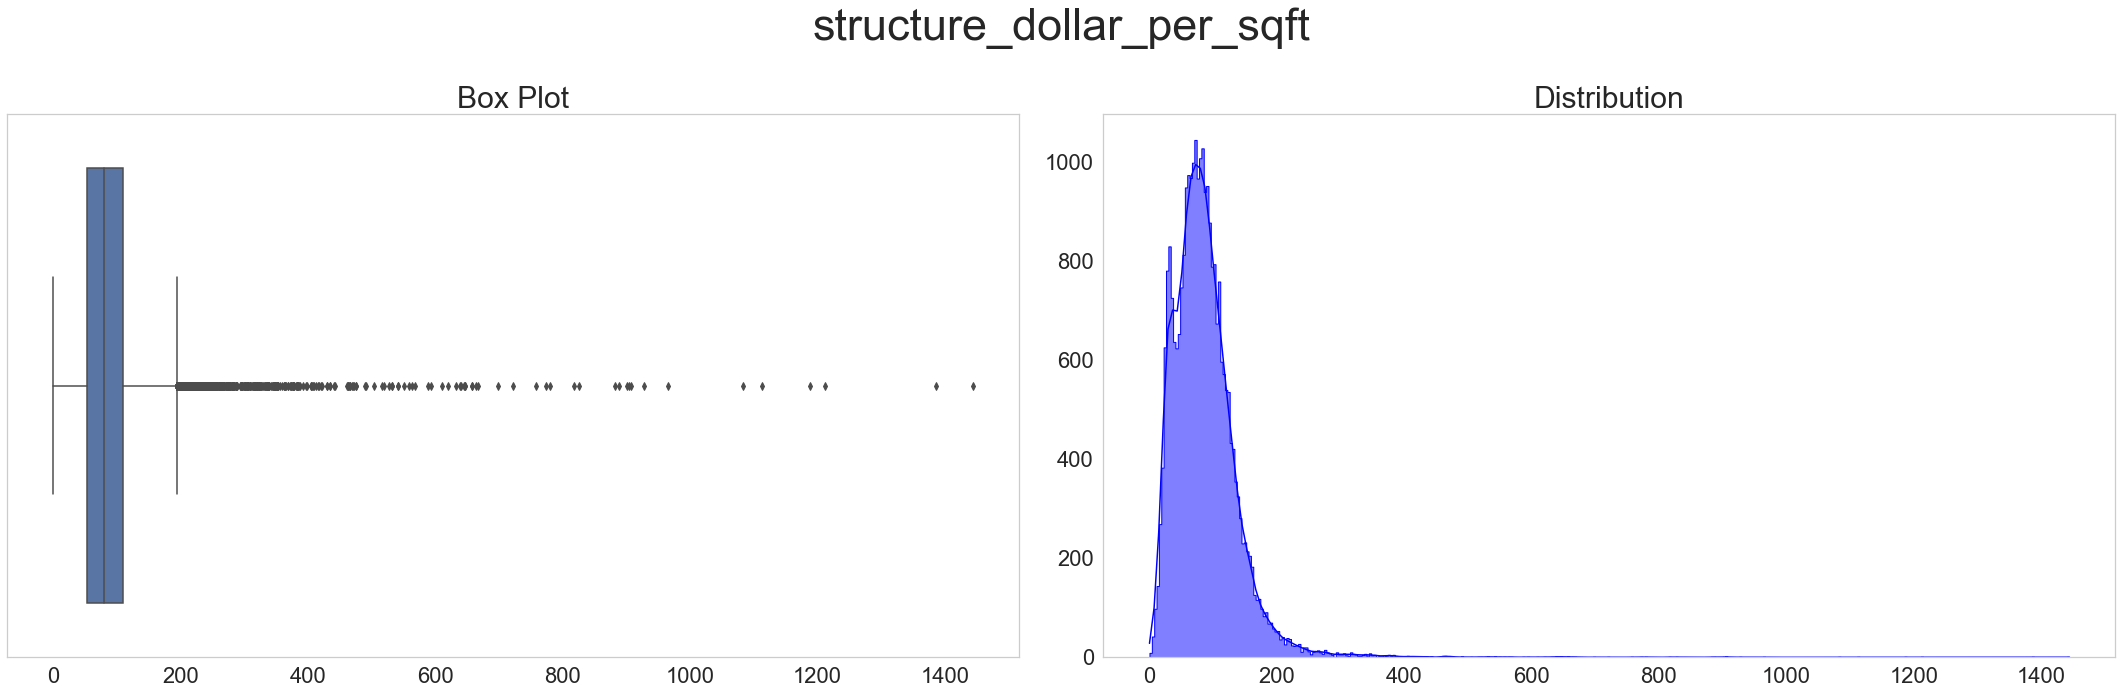

Summary Statistics for structure_dollar_per_sqft
count    27805.000000
mean        87.373581
std         55.942407
min          0.258741
25%         53.918586
50%         80.283942
75%        110.002174
max       1444.221106
Name: structure_dollar_per_sqft, dtype: float64


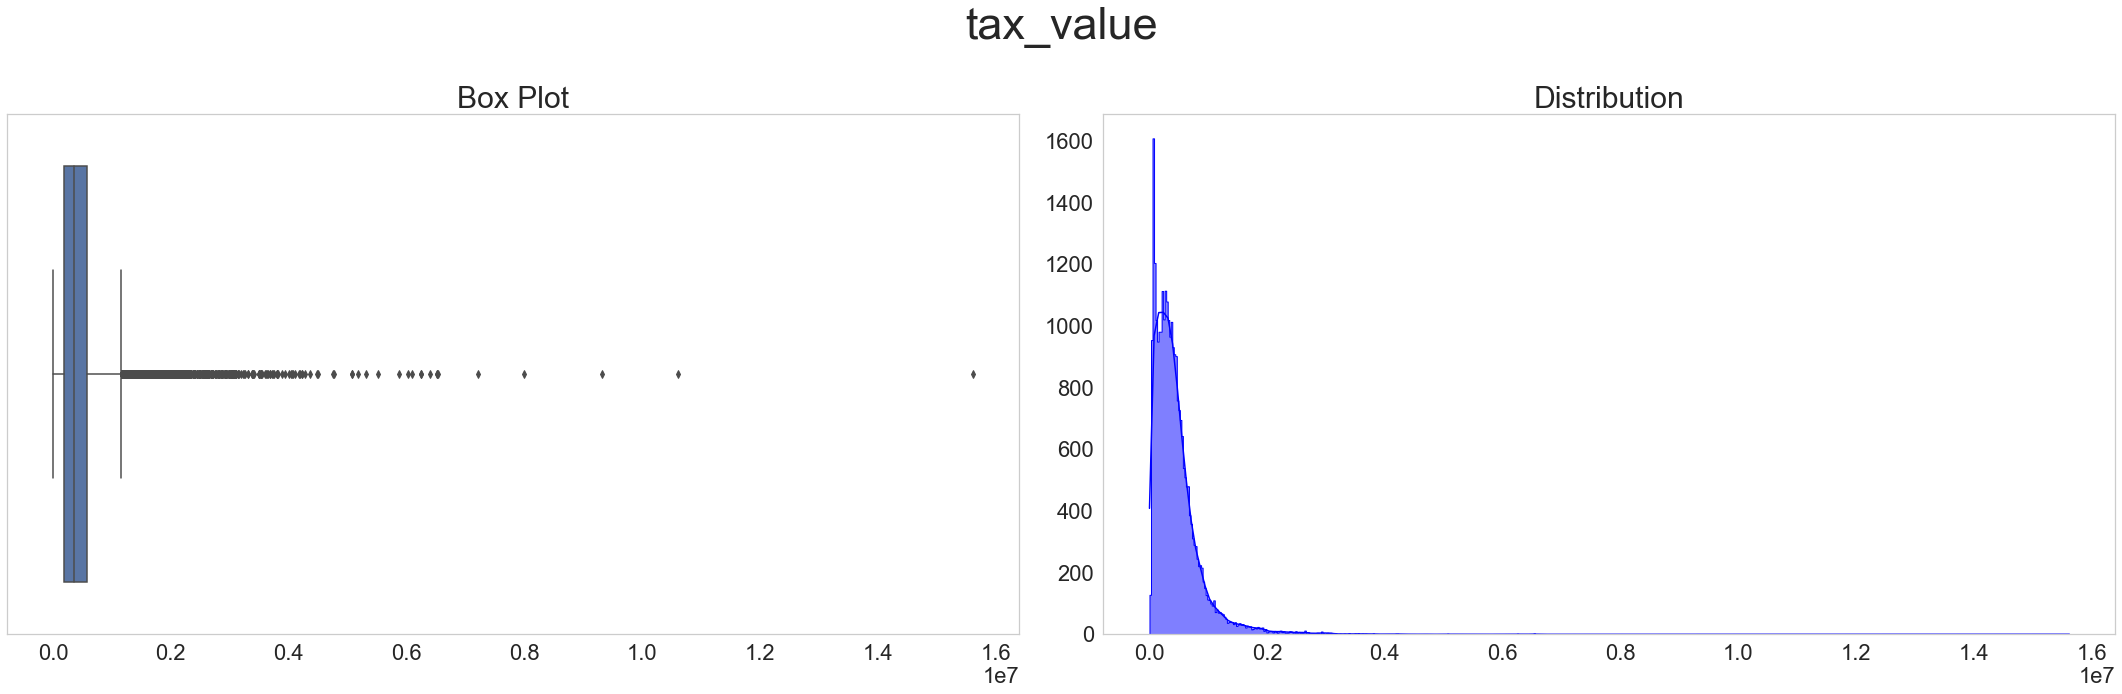

Summary Statistics for tax_value
count    2.780500e+04
mean     4.541208e+05
std      4.486173e+05
min      3.254000e+03
25%      1.866360e+05
50%      3.577080e+05
75%      5.772220e+05
max      1.561849e+07
Name: tax_value, dtype: float64


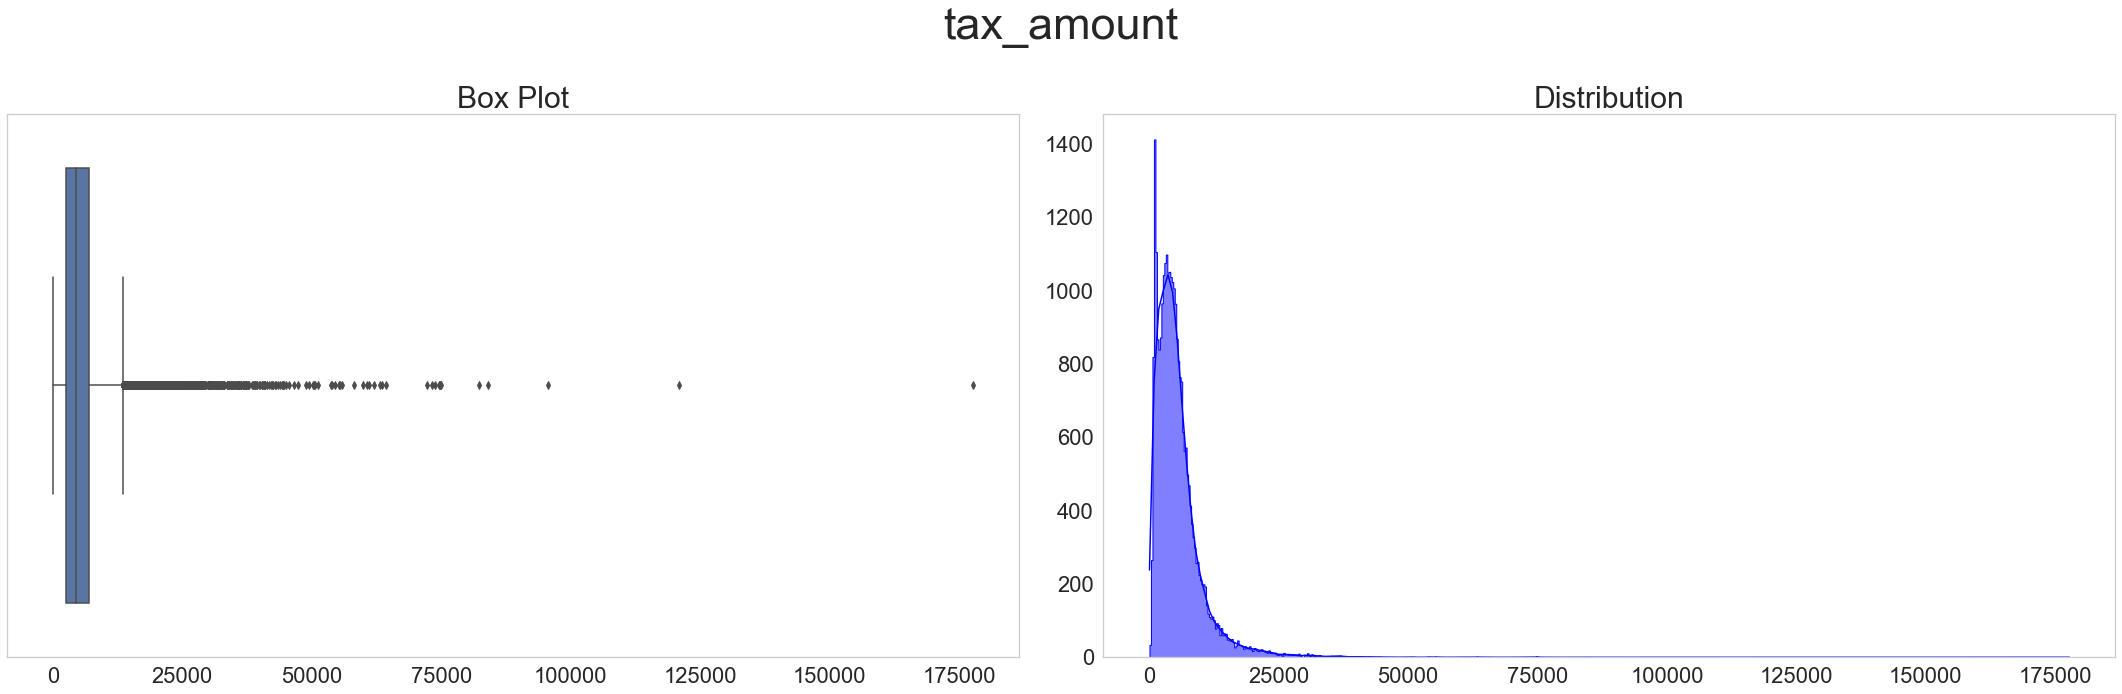

Summary Statistics for tax_amount
count     27805.000000
mean       5564.576977
std        5177.898600
min          49.180000
25%        2570.660000
50%        4462.460000
75%        6919.200000
max      177740.850000
Name: tax_amount, dtype: float64


In [14]:
univariate_e = ['sqft','age','bathsandbeds','structure_dollar_per_sqft','tax_value','tax_amount']

for i in univariate_e:
    e.explore_univariate(train, i)
    print(f'Summary Statistics for {i}\n{train[i].describe()}')

Takeaways:

- Normal: number of bathrooms and bedrooms (bathsandeds), latitude, and age
- Skewed right: tax amount, tax value, $ per sqft

### Bivariate Exploration

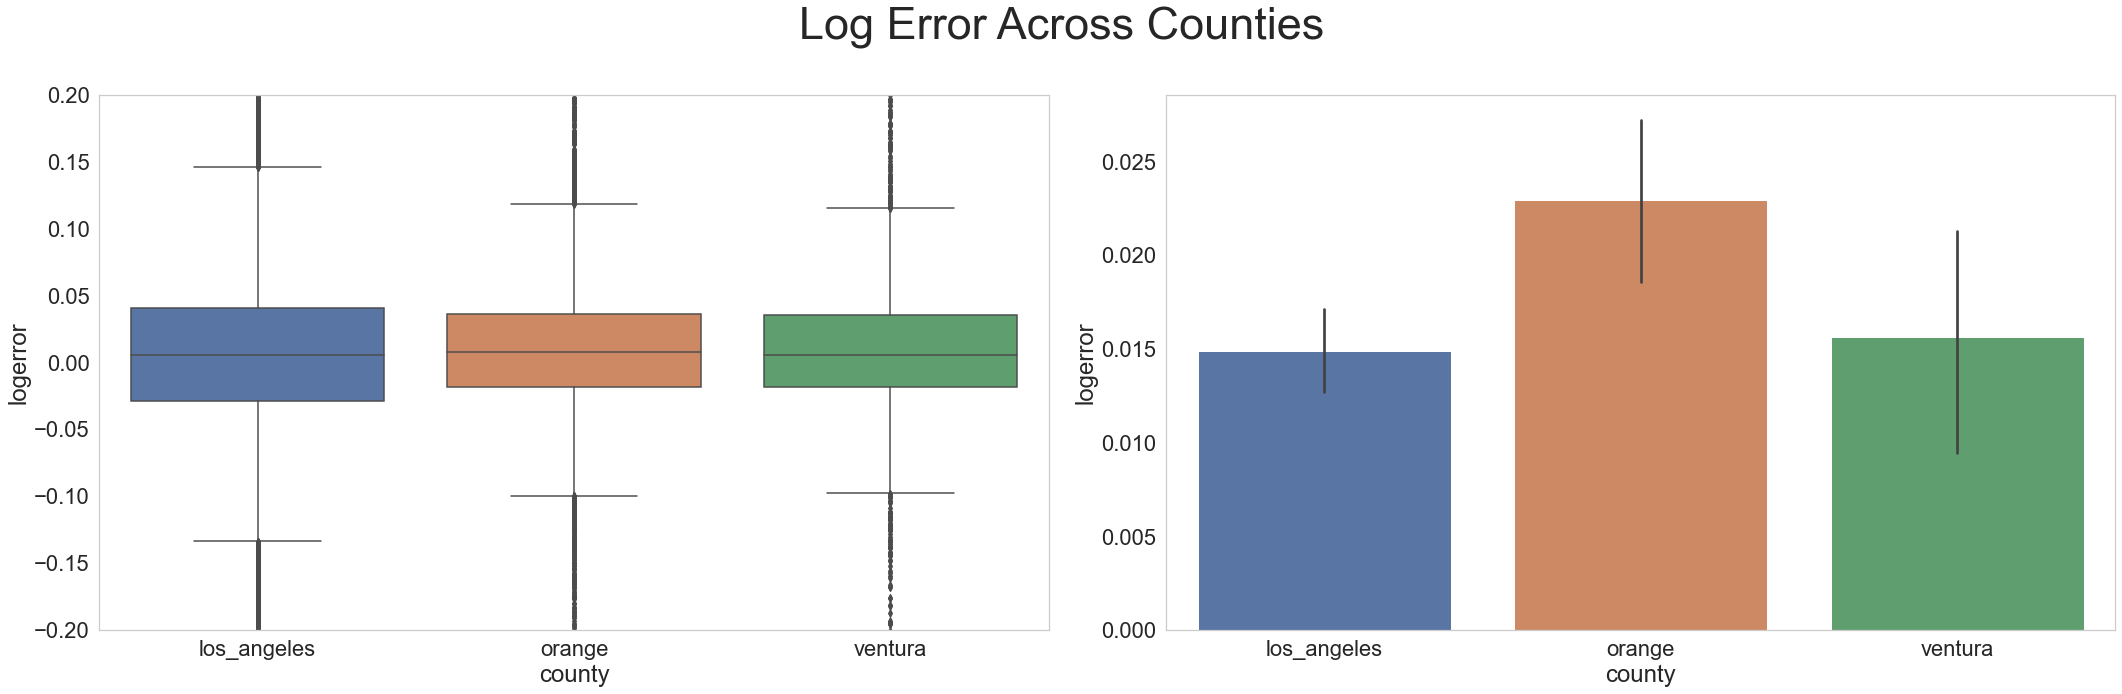

In [15]:
#logerror across counties (LA, Orange, and Ventura)

#set up figure size, font size, and turn off grid.
plt.figure(figsize=(30,10))
sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

#boxplot
plt.subplot(1, 2, 1)
sns.boxplot(train.county, train.logerror)
plt.ylim(-.2, .2)

#barplot
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='county',y='logerror')

#title
plt.suptitle('Log Error Across Counties', fontsize = 45)
plt.tight_layout()
plt.show()

In [16]:
#T-test between orange county and other county
null_hypothesis = "no difference in logerror between orange county and the other counties"
alternative_hypothesis = "there is a difference in log error between orange county and other counties"
a = 0.05 #a for alpha 

orange_logerror=train[train.county=='orange'].logerror
other_logerror = train[train.county!='orange'].logerror
t, p = stats.ttest_ind(orange_logerror, other_logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between orange county and the other counties
There is evidence to suggest: there is a difference in log error between orange county and other counties


Age and LogError


<Figure size 504x864 with 0 Axes>

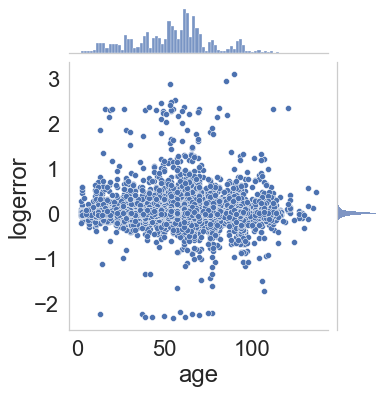

In [17]:
#Property age and log error
print('Age and LogError')
plt.figure(figsize=(7,12))
sns.jointplot(x='age', y='logerror', data=train)
plt.xlabel('Age')
plt.ylabel('Log Error')
plt.show()

In [18]:
#Correlation test between property age vs logerror
null_hypothesis = "no evident correlation logerror between property age"
alternative_hypothesis = "there is evident correlation between log error and property age"
a = 0.05 #a for alpha 

corr, p = stats.pearsonr(train.age,train.logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Fail to reject null hypothesis that: no evident correlation logerror between property age There is not sufficient evidence to reject it.


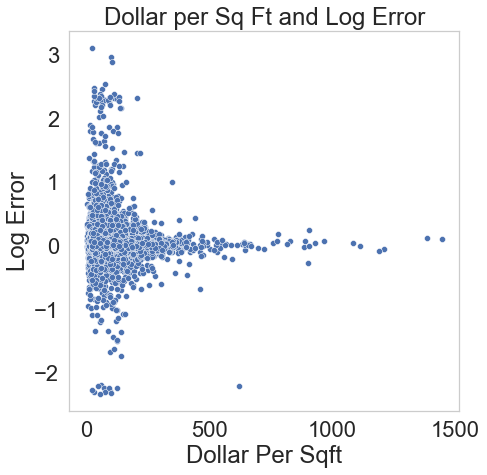

In [19]:
#Dollar/Sqft and Log Error
plt.figure(figsize=(7,7))
sns.scatterplot(x='structure_dollar_per_sqft', y='logerror', data=train)
plt.xlabel('Dollar Per Sqft')
plt.ylabel('Log Error')
plt.title('Dollar per Sq Ft and Log Error')
plt.show()

In [20]:
#Correlation test between logerror and structure_dollar_per_sqft
null_hypothesis = "no evident correlation logerror between dollar per sqft"
alternative_hypothesis = "there is evident correlation between log error and dollar per sqft"
a = 0.05 #a for alpha 

corr, p = stats.pearsonr(train.structure_dollar_per_sqft,train.logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no evident correlation logerror between dollar per sqft
There is evidence to suggest: there is evident correlation between log error and dollar per sqft


In [21]:
#let's add log error bins
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

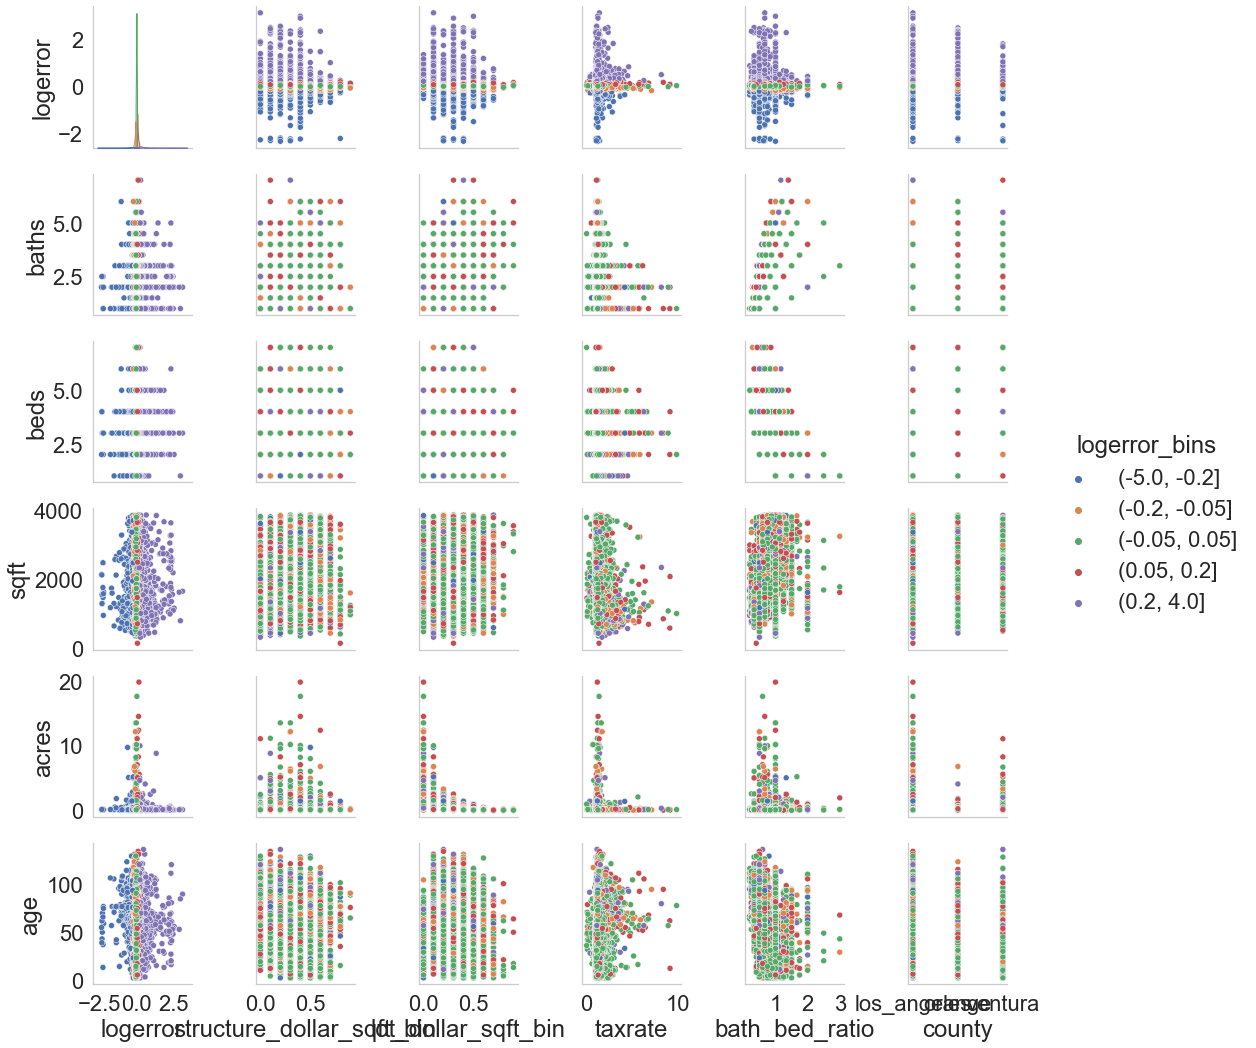

In [22]:
#the pairplot
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror','structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 'bath_bed_ratio','county'],
             y_vars = ['logerror', 'baths','beds', 'sqft', 'acres', 'age'])

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

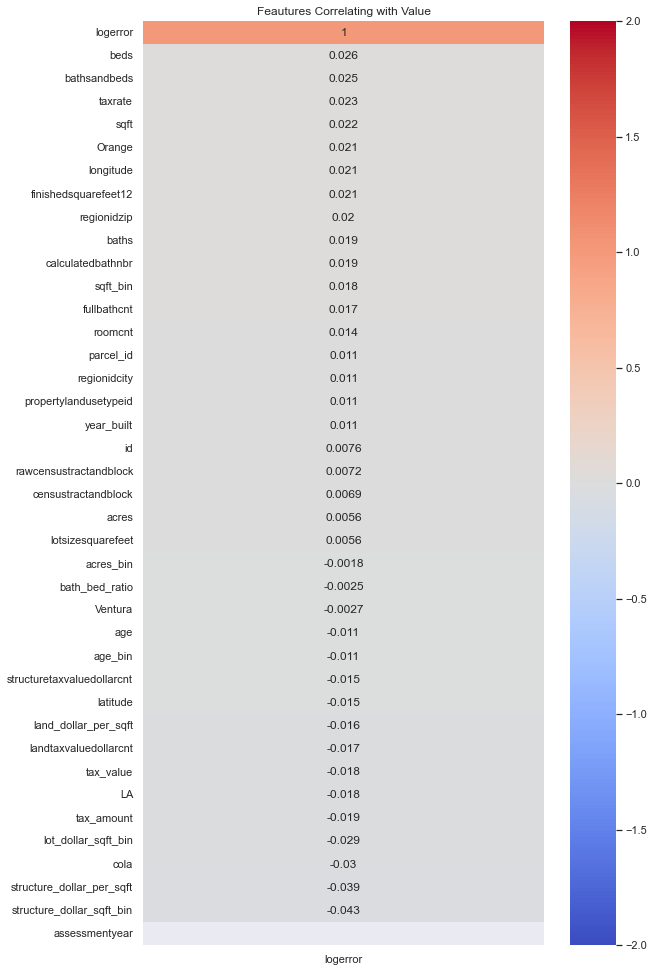

In [23]:
#let's focus on my target
e.get_zillow_heatmap(train,'logerror')

Takeaways

- logerror does not correlate well with any features

### Multivariate Exploration

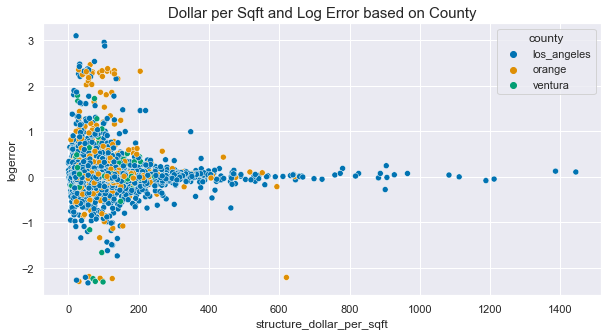

In [24]:
#Dollar per sqft vs logerror based on county
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

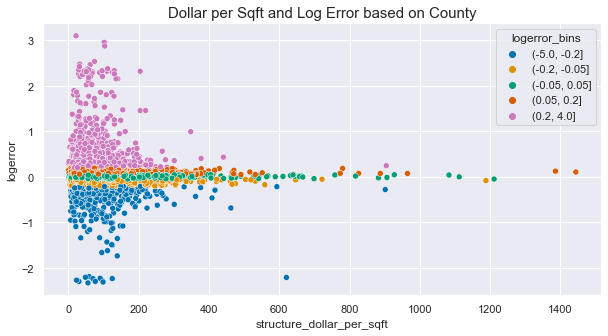

In [25]:
#Same above but using the log error bins
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='logerror_bins', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

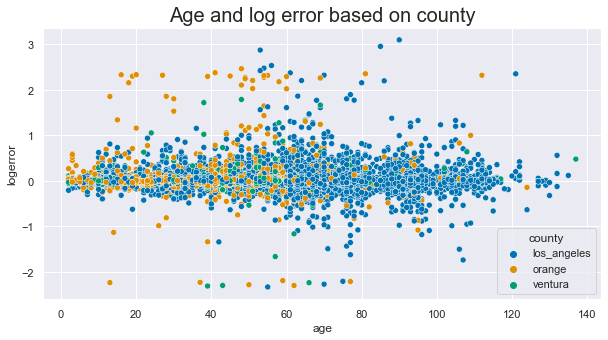

In [26]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Age and log error based on county', fontsize=20)
plt.show()

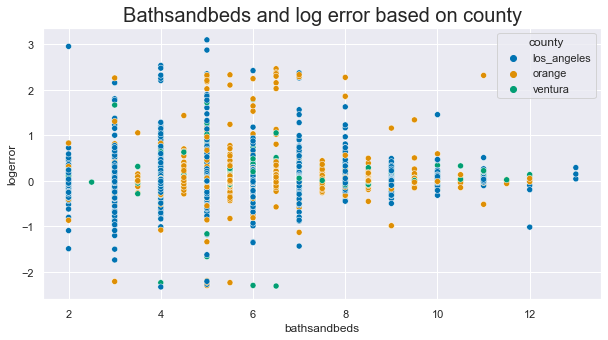

In [27]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='bathsandbeds',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Bathsandbeds and log error based on county', fontsize=20)
plt.show()

In [28]:
#Main purpose of logerror_bins is for exploration, other than that just drop the columns
train = train.drop(columns=['logerror_bins'])

Exploration Takeaways:

- Log error is affected by property age, price per square foot, number of bedrooms, and number of bathrooms.
- More variance in log error with cheaper houses
- Visually appears that Orange county has the most variance in log error
- Heatmap suggests none of the features (on their own) are strongly correlated to logerror.
- Let's move on to clustering

### Data explore with clusters

In this section, several clusters are created to try and discern potential groupings with significantly difference variances in log_error between those populations. The number of clusters was determined using the elbow plot method to find when change in inertia to k has dropped relative to lower k values. 

Using analysis of variance (ANOVA) test, those clusters that can reject the respective null hypothesis will be carried into potential model features.

#### Hypotheses and Significance Level

H0: There is no significant difference in log_error between cluster groups for structure_square_feet, and age.

Ha: There is a significant difference in log_error between cluster groups for structure_square_feet and age.

In [29]:
#Significance Level
α = 0.05

Clusters based on age property and square footage


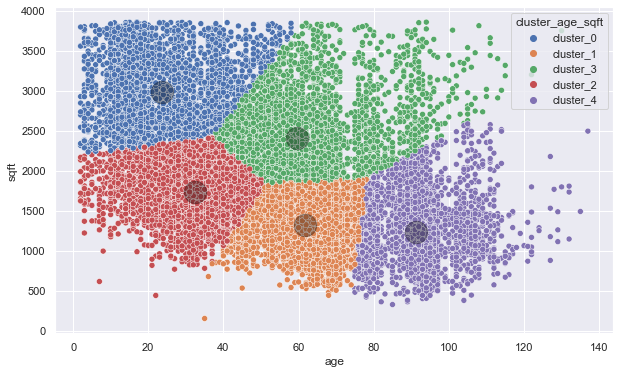

In [30]:
#Let's look at property age and square footage
X_features = ['age', 'sqft']
train, X_scaled, scaler, kmeans, centroids = e.create_cluster(train, validate, test, X_features, 5,'cluster_age_sqft')
e.create_scatter_plot('age','sqft',train,kmeans, X_scaled, scaler,'cluster_age_sqft')
print('Clusters based on age property and square footage')

In [31]:
agescluster_0=train[train.cluster_age_sqft == 'cluster_0'].logerror
agescluster_1=train[train.cluster_age_sqft == 'cluster_1'].logerror
agescluster_2=train[train.cluster_age_sqft == 'cluster_2'].logerror
agescluster_3=train[train.cluster_age_sqft == 'cluster_3'].logerror
agescluster_4=train[train.cluster_age_sqft == 'cluster_4'].logerror 

In [32]:
#Statistically significant differences in log error means between these groups? 
f, p = f_oneway(agescluster_0,agescluster_1,agescluster_2,agescluster_3,agescluster_4)
f,p

(2.9799539917519953, 0.017973956070462975)

In [33]:
if p < α:
    print(f'Reject null hypothesis')
else:
    print(f'Fail to reject null hypothesis')

Reject null hypothesis


H0: There is no significant difference in log_error between cluster groups for latitude and longitude.

Ha: There is a significant difference in log_error between cluster groups for latitude and longitude.

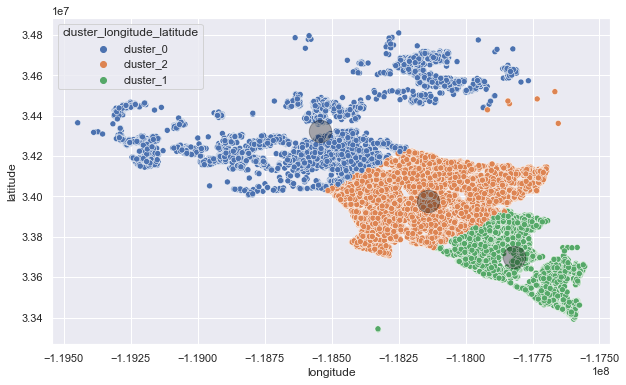

In [34]:
#Let's look at longitude and latitude
#selecting the features we want to cluster on
X_features2 = ['longitude', 'latitude']
train, X_scaled, scaler, kmeans, centroids = e.create_cluster(train,validate,test, X_features2, 3,'cluster_longitude_latitude')
e.create_scatter_plot('longitude','latitude',train,kmeans, X_scaled, scaler,'cluster_longitude_latitude')

In [35]:
l_cluster_0 = train[train.cluster_longitude_latitude == 'cluster_0'].logerror
l_cluster_1 = train[train.cluster_longitude_latitude == 'cluster_1'].logerror
l_cluster_2 = train[train.cluster_longitude_latitude == 'cluster_2'].logerror

In [36]:
#Statistically significant differences in log error means between these groups? 
f, p = f_oneway(l_cluster_0,l_cluster_1,l_cluster_2)
f, p

(4.074820832265479, 0.017005410517702546)

In [37]:
if p < α:
    print(f'Reject null hypothesis')
else:
    print(f'Fail to reject null hypothesis')

Reject null hypothesis


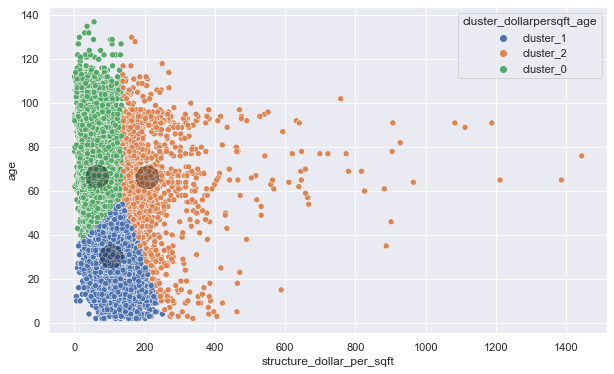

In [38]:
#Let's look at sqft and bathsandbeds
#selecting the features we want to cluster on
X_features3 = ['structure_dollar_per_sqft','age']
train, X_scaled, scaler, kmeans, centroids = e.create_cluster(train,validate,test, X_features3, 3,'cluster_dollarpersqft_age')
e.create_scatter_plot('structure_dollar_per_sqft','age',train,kmeans, X_scaled, scaler,'cluster_dollarpersqft_age')

In [39]:
#add predictions to our train
#train['dollarpersqft_age_cluster'] = kmeans.predict(X_scaled)

In [40]:
dollarsqfta_cluster_0 = train[train.cluster_dollarpersqft_age == 'cluster_0'].logerror
dollarsqfta_cluster_1 = train[train.cluster_dollarpersqft_age == 'cluster_1'].logerror
dollarsqfta_cluster_2 = train[train.cluster_dollarpersqft_age == 'cluster_2'].logerror

In [41]:
#Statistically significant differences in log error means between these groups? 
f, p = f_oneway(dollarsqfta_cluster_0,dollarsqfta_cluster_1,dollarsqfta_cluster_2)
f, p

(16.272642353981905, 8.649966241486589e-08)

In [42]:
if p < α:
    print(f'Reject null hypothesis')
else:
    print(f'Fail to reject null hypothesis')

Reject null hypothesis


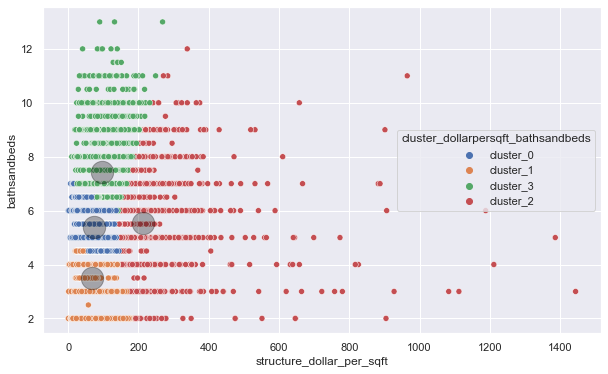

In [43]:
#Let's look at sqft and bathsandbeds
X_features4 = ['structure_dollar_per_sqft','bathsandbeds']
train, X_scaled, scaler, kmeans, centroids = e.create_cluster(train,validate,test, X_features4, 4,'cluster_dollarpersqft_bathsandbeds')
e.create_scatter_plot('structure_dollar_per_sqft','bathsandbeds',train,kmeans, X_scaled, scaler,'cluster_dollarpersqft_bathsandbeds')

In [44]:
#add predictions to our train
#train['dollarpersqft_bathsandbeds_cluster'] = kmeans.predict(X_scaled)

In [45]:
dollarsqftb_cluster_0=train[train.cluster_dollarpersqft_bathsandbeds == 'cluster_0'].logerror
dollarsqftb_cluster_1=train[train.cluster_dollarpersqft_bathsandbeds == 'cluster_1'].logerror
dollarsqftb_cluster_2=train[train.cluster_dollarpersqft_bathsandbeds == 'cluster_2'].logerror
dollarsqftb_cluster_3=train[train.cluster_dollarpersqft_bathsandbeds == 'cluster_3'].logerror

In [46]:
#Statistically significant differences in log error means between these groups? 
f, p = f_oneway(dollarsqftb_cluster_0,dollarsqftb_cluster_1,dollarsqftb_cluster_2,dollarsqftb_cluster_3)
f, p

(11.428294158031619, 1.7422413611170438e-07)

In [47]:
if p < α:
    print(f'Reject null hypothesis')
else:
    print(f'Fail to reject null hypothesis')

Reject null hypothesis


### Modeling

In [48]:
#create a list of columns
list_cluster = train.columns.to_list()
#get only clusters columns
cat_var = list_cluster[-4:]

In [49]:
#train
dummies =  pd.get_dummies(train[cat_var])
train = pd.concat([train, dummies], axis=1)
train = train.drop(columns=cat_var)

#validate
dummies =  pd.get_dummies(validate[cat_var])
validate = pd.concat([validate, dummies], axis=1)
validate = validate.drop(columns=cat_var)

#test
dummies =  pd.get_dummies(test[cat_var])
test = pd.concat([test, dummies], axis=1)
test = test.drop(columns=cat_var)

In [50]:
#new X_train, y_train, X_validate, y_validate, X_test, y_test
X_train, y_train, X_validate, y_validate, X_test, y_test = w.split_X_y(train, validate, test, 'logerror')

In [51]:
#get object columns, and numeric columns. Using numeric columns to scale.
obj_cols = w.get_object_cols(X_train)
num_cols = w.get_numeric_X_cols(X_train, obj_cols)

In [52]:
#scale our X_train, X_validate, and X_test with standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = w.standard_scale_data(X_train[num_cols],X_validate[num_cols],X_test[num_cols])

In [53]:
#let's find out which features use to model
selected_features = m.select_rfe(X_train_scaled, y_train, 6, LinearRegression())

The top 6 selected feautures based on the the RFE class are: ['LA', 'Orange', 'Ventura', 'cluster_longitude_latitude_cluster_0', 'cluster_longitude_latitude_cluster_1', 'cluster_longitude_latitude_cluster_2']
LA                                               1
cluster_longitude_latitude_cluster_2             1
cluster_longitude_latitude_cluster_1             1
cluster_longitude_latitude_cluster_0             1
Orange                                           1
Ventura                                          1
beds                                             2
bathsandbeds                                     3
baths                                            4
calculatedbathnbr                                5
rawcensustractandblock                           6
sqft                                             7
finishedsquarefeet12                             8
cola                                             9
sqft_bin                                        10
structure_dollar_sqft_bin 

In [54]:
#conver y_train y _ validate to df
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [55]:
#Create baseline
metric_df, rmse_mean_train, rmse_mean_validate, rmse_median_train, rmse_median_validate, r2_baseline = m.create_baseline(y_train, y_validate, 'logerror')

In [56]:
metric_df

,model,rmse_train,rmse_validate,r^2_value
0,Mean Baseline,0.166345,0.179763,-0.000025


In [57]:
#Linear regression model
rmse_lm_train, rmse_lm_validate, r2_lm_value = m.create_model(LinearRegression(normalize=True), X_train_scaled[selected_features], X_validate_scaled[selected_features], y_train, y_validate, 'logerror')

#Lassorlars model
rmse_lars_train, rmse_lars_validate, r2_lars_value = m.create_model(LassoLars(alpha=1.0), X_train_scaled[selected_features], X_validate_scaled[selected_features], y_train, y_validate, 'logerror')

#Tweedie regressor model
rmse_glm_train, rmse_glm_validate, r2_glm_value = m.create_model(TweedieRegressor(power =0, alpha=0.00), X_train_scaled[selected_features], X_validate_scaled[selected_features], y_train, y_validate, 'logerror')

In [58]:
#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=3)

#fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[selected_features])

In [59]:
#Polymial model
rmse_pf_train, rmse_pf_validate, r2_pf_value = m.create_model(LinearRegression(normalize=True), X_train_degree3, X_validate_degree3, y_train, y_validate,'logerror')

In [60]:
# add model's performance to metric df
metric_df = metric_df.append({
    'model': 'Linear_regression',
    'rmse_train': rmse_lm_train,
    'rmse_validate': rmse_lm_validate,
    'r^2_value': r2_lm_value}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'Lassolars',
    'rmse_train': rmse_lars_train,
    'rmse_validate': rmse_lars_validate,
    'r^2_value': r2_lars_value}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'Tweedie_regressor',
    'rmse_train': rmse_glm_train,
    'rmse_validate': rmse_glm_validate,
    'r^2_value': r2_glm_value}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'Polynomial_regression',
    'rmse_train': rmse_pf_train,
    'rmse_validate': rmse_pf_validate,
    'r^2_value': r2_pf_value}, ignore_index=True)

In [61]:
#Create a report for side by side comparison to select which model has lowest rmse out of sample
m.report(metric_df)

These are the models that perform better than our baseline rmse: 0.17976346587949524


,model,rmse_validate
1,Linear_regression,0.179724
3,Tweedie_regressor,0.179727


-----------------------------------------------------------------------------------------------
   ********** The model with the less  rmse_validate  is Linear_regression  rmse:0.179724 **********             
-----------------------------------------------------------------------------------------------
 
The model with r^2 validate closer to 1 is  Linear_regression


,model,rmse_train,rmse_validate,r^2_value
0,Mean Baseline,0.166345,0.179763,-0.000025
1,Linear_regression,0.166303,0.179724,0.000417
2,Lassolars,0.166345,0.179763,-0.000025
3,Tweedie_regressor,0.166301,0.179727,0.000380
4,Polynomial_regression,0.166494,0.179863,-0.001128
